# Measurements of Relativistic Corrections

Start in the appropriate notebook directory.

In [1]:
# %cd /mnt/lustre/mikewang/projects/HorizonGRound/notebooks/

Set up the appropriate paths.

In [2]:
import os, sys

current_file_dir = os.getcwd()
sys.path.insert(0, "".join([current_file_dir, "/../"]))
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

from config.program import data_dir, stylesheet

publication_dir = data_dir/"output"/"publication"

Import the appropriate packages.

In [3]:
import glob
import re
from collections import defaultdict

import corner
import h5py
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator
from nbodykit.cosmology import Planck15

from horizonground.clustering_modification import relativistic_correction_value

plt.style.use(stylesheet)

## Relativistic correction quantiles

In [4]:
quantile_levels = [0.022750, 0.158655, 0.5, 0.841345, 0.977250]

In [5]:
dense_redshifts = []
gz_quantiles = defaultdict(list)
for chain_file in sorted(glob.glob("/".join([str(publication_dir), "dense_points", "relcrct_z*"]))):
    dense_redshifts.append(float(re.search("_z(?P<redshift>.*?)_", chain_file).group('redshift')))
    with h5py.File(chain_file, 'r') as chain_data:
        distilled = chain_data['distill/chain'][()]
        gz_q = corner.quantile(distilled[:], q=quantile_levels)
    for sigma_level_idx, sigma_level in enumerate([-2, -1, 0, 1, 2]):
        gz_quantiles[sigma_level].append(gz_q[sigma_level_idx])

In [6]:
dense_redshifts = []
gz_evol_quantiles = defaultdict(list)
for chain_file in sorted(glob.glob("/".join([str(publication_dir), "dense_points", "relcrct_evol_z*"]))):
    dense_redshifts.append(float(re.search("_z(?P<redshift>.*?)_", chain_file).group('redshift')))
    with h5py.File(chain_file, 'r') as chain_data:
        distilled = chain_data['distill/chain'][()]
        gz_evol_q = corner.quantile(distilled[:], q=quantile_levels)
    for sigma_level_idx, sigma_level in enumerate([-2, -1, 0, 1, 2]):
        gz_evol_quantiles[sigma_level].append(gz_evol_q[sigma_level_idx])

In [7]:
dense_redshifts = []
gz_magn_quantiles = defaultdict(list)
for chain_file in sorted(glob.glob("/".join([str(publication_dir), "dense_points", "relcrct_magn_z*"]))):
    dense_redshifts.append(float(re.search("_z(?P<redshift>.*?)_", chain_file).group('redshift')))
    with h5py.File(chain_file, 'r') as chain_data:
        distilled = chain_data['distill/chain'][()]
        gz_magn_q = corner.quantile(distilled[:], q=quantile_levels)
    for sigma_level_idx, sigma_level in enumerate([-2, -1, 0, 1, 2]):
        gz_magn_quantiles[sigma_level].append(gz_magn_q[sigma_level_idx])

## Relativistic correction measurements

In [8]:
estimate_levels = [0.158655, 0.5, 0.841345]

In [9]:
measured_redshifts = []
gz_estimates = defaultdict(list)
for chain_file in sorted(glob.glob("/".join([str(publication_dir), "eBOSS_binning", "relcrct_z*"]))):
    measured_redshifts.append(float(re.search("_z(?P<redshift>.*?)_", chain_file).group('redshift')))
    with h5py.File(chain_file, 'r') as chain_data:
        distilled = chain_data['distill/chain'][()]
        gz_e = corner.quantile(distilled[:], q=estimate_levels)
    for sigma_level_idx, sigma_level in enumerate([-1, 0, 1]):
        gz_estimates[sigma_level].append(gz_e[sigma_level_idx])

In [10]:
measured_redshifts = []
gz_evol_estimates = defaultdict(list)
for chain_file in sorted(glob.glob("/".join([str(publication_dir), "eBOSS_binning", "relcrct_evol_z*"]))):
    measured_redshifts.append(float(re.search("_z(?P<redshift>.*?)_", chain_file).group('redshift')))
    with h5py.File(chain_file, 'r') as chain_data:
        distilled = chain_data['distill/chain'][()]
        gz_evol_e = corner.quantile(distilled[:], q=estimate_levels)
    for sigma_level_idx, sigma_level in enumerate([-1, 0, 1]):
        gz_evol_estimates[sigma_level].append(gz_evol_e[sigma_level_idx])

In [11]:
measured_redshifts = []
gz_magn_estimates = defaultdict(list)
for chain_file in sorted(glob.glob("/".join([str(publication_dir), "eBOSS_binning", "relcrct_magn_z*"]))):
    measured_redshifts.append(float(re.search("_z(?P<redshift>.*?)_", chain_file).group('redshift')))
    with h5py.File(chain_file, 'r') as chain_data:
        distilled = chain_data['distill/chain'][()]
        gz_magn_e = corner.quantile(distilled[:], q=estimate_levels)
    for sigma_level_idx, sigma_level in enumerate([-1, 0, 1]):
        gz_magn_estimates[sigma_level].append(gz_magn_e[sigma_level_idx])

## Relativistic  contribution constraints

In [12]:
background_corrections = np.asarray([relativistic_correction_value(z, cosmo=Planck15) for z in dense_redshifts])

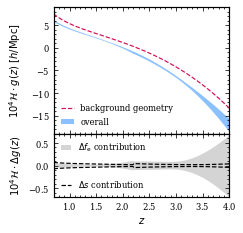

In [13]:
ALPHA = 0.5
SCALING = 10**4

fig = plt.figure("relativistic correction contributions", figsize=(3.15, 3.5))

overall = plt.subplot2grid((3, 1), (0, 0), rowspan=2)

overall.fill_between(
    dense_redshifts, SCALING * np.asarray(gz_quantiles[-2]), SCALING * np.asarray(gz_quantiles[2]),
    facecolor='#1A85FF', alpha=ALPHA, label='overall'
)
overall.plot(
    dense_redshifts, SCALING * background_corrections, 
    ls='--', color='#D41159', label='background geometry'
)

overall.legend(handlelength=1.5)
overall.tick_params(axis='x', which='both', labelbottom=False)
overall.set_yticks(np.arange(-0.002 * SCALING, 0.001 * SCALING, step=0.0005*SCALING))
overall.yaxis.set_minor_locator(AutoMinorLocator())
overall.set_ylim(-0.0019 * SCALING, 0.0009 * SCALING)
overall.set_ylabel(r"$10^4\mathcal{H}\cdot g(z)\ [h/\mathrm{Mpc}]$", labelpad=8)

uncertainty = plt.subplot2grid((3, 1), (2, 0), sharex=overall)

evol = uncertainty.fill_between(
    dense_redshifts, 
    SCALING * np.subtract(gz_evol_quantiles[-1], gz_evol_quantiles[0]),
    SCALING * np.subtract(gz_evol_quantiles[1], gz_evol_quantiles[0]),
    facecolor='0.67', alpha=ALPHA, zorder=1, label=r'$\Delta f_\mathrm{e}$ contribution'
)
magn, = uncertainty.plot(
    dense_redshifts, SCALING * np.subtract(gz_magn_quantiles[-1], gz_magn_quantiles[0]), 
    c='k', ls='--', label=r'$\Delta s$ contribution'
)
uncertainty.plot(
    dense_redshifts, SCALING * np.subtract(gz_magn_quantiles[1], gz_magn_quantiles[0]), 
    c='k', ls='--'
)

first_legend = plt.legend(handles=[evol], loc='upper left')
ax = plt.gca().add_artist(first_legend)
second_legend = plt.legend(handles=[magn], loc='lower left')

uncertainty.set_yticks(np.arange(-0.0001 * SCALING, 0.0001 * SCALING, step=0.00005*SCALING))
uncertainty.xaxis.set_minor_locator(AutoMinorLocator())
uncertainty.yaxis.set_minor_locator(AutoMinorLocator())
uncertainty.set_xlim(min(dense_redshifts), max(dense_redshifts))
uncertainty.set_ylim(-0.00007 * SCALING, 0.00007 * SCALING)
uncertainty.set_xlabel(r"$z$")
uncertainty.set_ylabel(r"$10^4\mathcal{H}\cdot\Delta g(z)$", labelpad=4)

fig.savefig(publication_dir/"gallery"/"relativistic_correction_breakdown.pdf")